# Final project: Fault Segmentation 
### This assignment is to implement convolutional neural networks for fault data segmentation
### AI in geosciences, ESS1502

#### Task: Train and validate your networks/models on the provide dataset. You are free to use Tensorflow, Keras, or Pytorch to implement your networks. The test result need to upload to the kaggle platform to get the final score 

In [1]:
from modelarts.session import Session
session = Session()
session.download_data(bucket_path="20ai-project/data.npy", path="/home/ma-user/work/data.npy")
session.download_data(bucket_path="20ai-project/label.npy", path="/home/ma-user/work/label.npy")
session.download_data(bucket_path="20ai-project/new_test_data.npy", path="/home/ma-user/work/new_test_data.npy")
# session.download_data(bucket_path="20ai-project/new_test_label.npy", path="/home/ma-user/work/new_test_label.npy")

Successfully download file 20ai-project/data.npy from OBS to local /home/ma-user/work/data.npy
Successfully download file 20ai-project/label.npy from OBS to local /home/ma-user/work/label.npy
Successfully download file 20ai-project/new_test_data.npy from OBS to local /home/ma-user/work/new_test_data.npy
Successfully download file 20ai-project/new_test_label.npy from OBS to local /home/ma-user/work/new_test_label.npy


## 1. Import the requirements

In [4]:
import os
import random
import numpy as np
import skimage
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard
from keras import backend as keras
from keras.models import load_model
from keras.utils import to_categorical
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
seed(12345)

## 2. Load the train dataset

In [5]:
# select your own datapath
data = np.load('data.npy')
label = np.load('label.npy')

### 2.1 visualize the train dataset

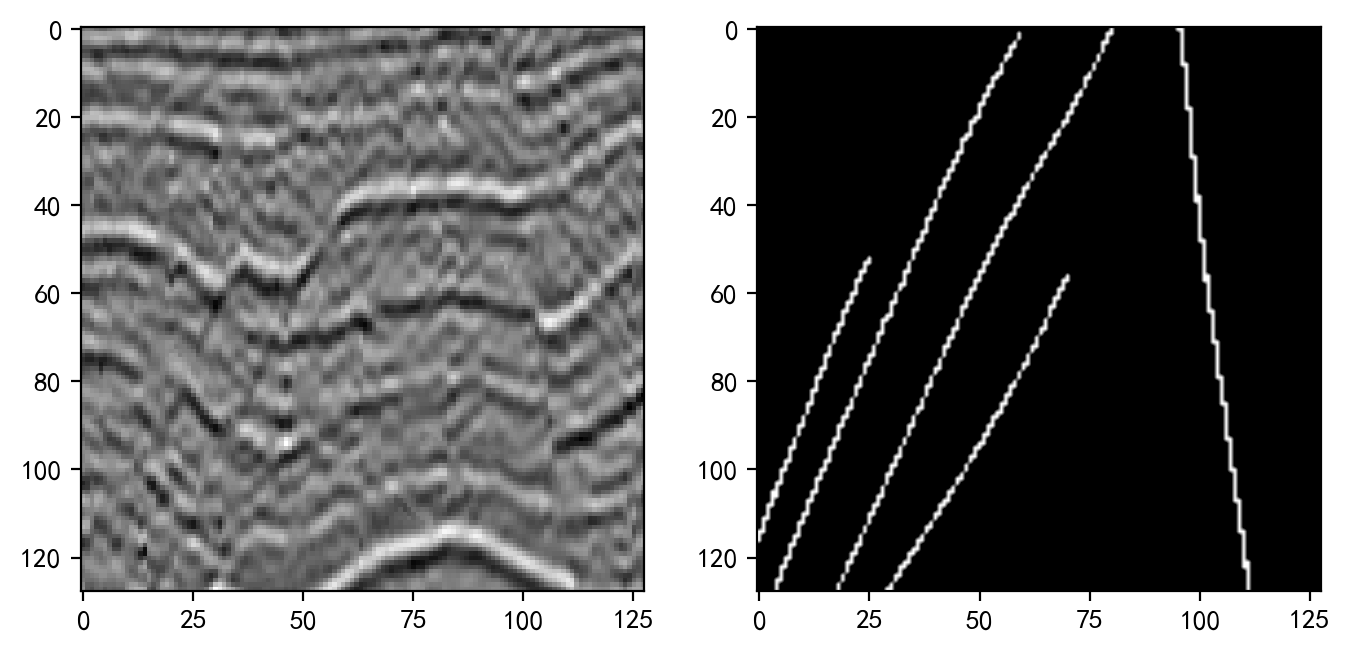

In [6]:
j = 1500
plt.figure(figsize=(8,4),dpi=200)
plt.subplot(1,2,1)
plt.imshow(np.squeeze(data[j,:,:]),cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(np.squeeze(label[j,:,:]),interpolation="bilinear",vmin=0.2,vmax=1.0,cmap=plt.cm.gray)
figname = './fig/data_' +str(j)+'.jpg'
plt.savefig(figname)

In [7]:
def Z_ScoreNormalization(x):
    for i in range(len(x)):
        mu = np.average(x[i,:])
        sigma = np.std(x[i,:])
        x[i,:] = (x[i,:] - mu) / sigma;
    return x;

In [8]:
# normalize data
data = Z_ScoreNormalization(data)
data = np.reshape(data,(2000,128,128,1))
label = np.reshape(label,(2000,128,128,1))
# split the train_data and val_data
train_data = data[0:1600]
val_data = data[1600:2000]
train_label = label[0:1600]
val_label = label[1600:2000]
print(train_data.shape)
print(val_data.shape)
print(train_label.shape)
print(val_label.shape)

(1600, 128, 128, 1)
(400, 128, 128, 1)
(1600, 128, 128, 1)
(400, 128, 128, 1)


## 3. Define the neural network

In [10]:
def unet(pretrained_weights=None, input_size1=(None, None, 1)):
    input = Input(input_size1, name='input')
    conv1 = Conv2D(16, (3,3), activation='relu', padding='same')(input)
    conv1 = Conv2D(16, (3,3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(32, (3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3,3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(64, (3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(128, (3,3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3,3), activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2,2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, (3,3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, (3,3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2,2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(32, (3,3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(32, (3,3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2,2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(16, (3,3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(16, (3,3), activation='relu', padding='same')(conv7)

    conv8 = Conv2D(1, (1,1), activation='sigmoid')(conv7)
    model = Model(inputs=[input], outputs=[conv8])
    model.summary()
    return model

In [11]:
model = unet()
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy',metrics=['accuracy'])
# checkpoint
filepath="check1channel/fault-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]
print("data prepared, ready to train!")
# Fit the model
history = model.fit(train_data, train_label,
#                     validation_split=0.2,
                    validation_data=(val_data,val_label),
                    epochs=50,
                    batch_size=16,
                    shuffle=True,
                    verbose=1,callbacks=callbacks_list)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 160         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 1 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, None, None, 1 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

KeyboardInterrupt: 

## 4. Plot the loss and acc

In [15]:
def showHistory(history):
  # list all data in history
  print(history.history.keys())
  fig = plt.figure(figsize=(10,6))

  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy',fontsize=20)
  plt.ylabel('Accuracy',fontsize=20)
  plt.xlabel('Epoch',fontsize=20)
  plt.legend(['train', 'test'], loc='center right',fontsize=20)
  plt.tick_params(axis='both', which='major', labelsize=18)
  plt.tick_params(axis='both', which='minor', labelsize=18)
  plt.show()

  # summarize history for loss
  fig = plt.figure(figsize=(10,6))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss',fontsize=20)
  plt.ylabel('Loss',fontsize=20)
  plt.xlabel('Epoch',fontsize=20)
  plt.legend(['train', 'test'], loc='center right',fontsize=20)
  plt.tick_params(axis='both', which='major', labelsize=18)
  plt.tick_params(axis='both', which='minor', labelsize=18)
  plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


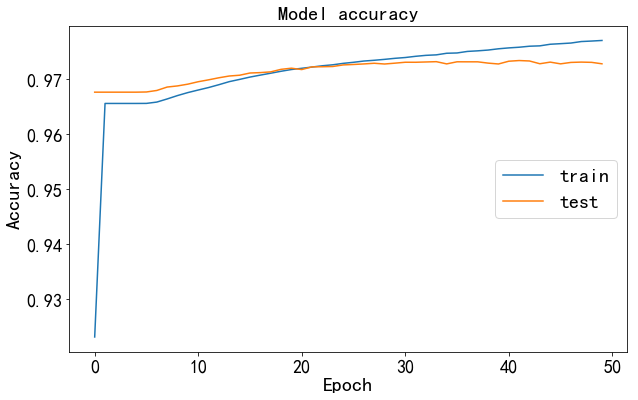

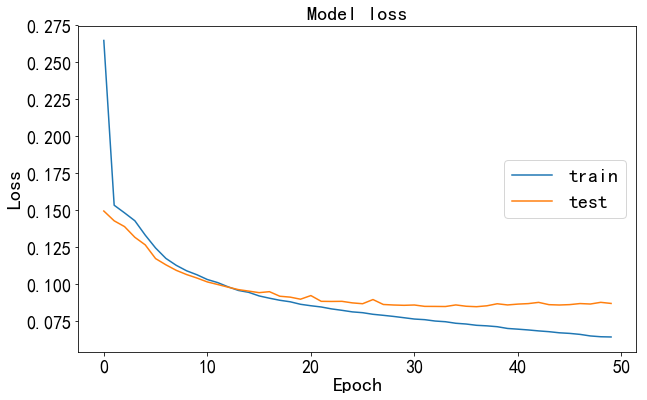

In [16]:
showHistory(history)

## 5. Validate the network using val_data

In [12]:
model = load_model('./check1channel/fault-50.hdf5')

In [13]:
# need a threshold to get the true predict result 
threshold = 0.4
result = model.predict(val_data)
result[result>threshold]=1
result[result<threshold]=0
# np.save('./Data/data/result.npy',result)

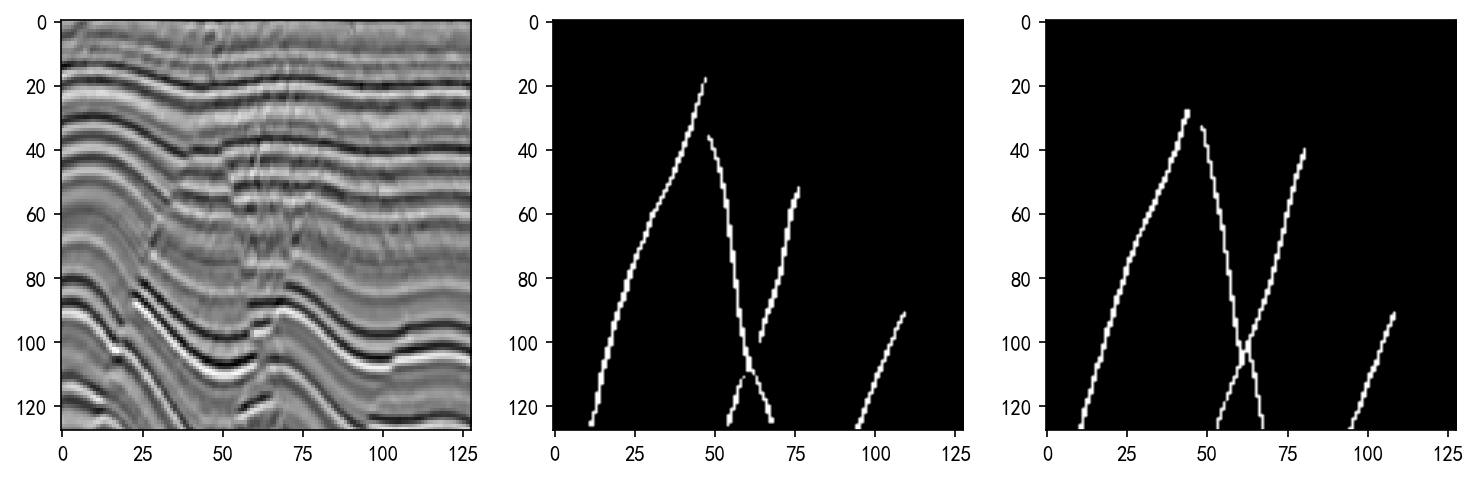

In [14]:
j=200
plt.figure(figsize=(12,4),dpi=150)
plt.subplot(1,3,1)
plt.imshow(np.squeeze(val_data[j,:,:,:]),cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.imshow(np.squeeze(result[j,:,:,:]),interpolation="bilinear",vmin=0.2,vmax=1.0,cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(np.squeeze(val_label[j,:,:]),interpolation="bilinear",vmin=0.2,vmax=1.0,cmap=plt.cm.gray)
# savefig
figname = './fig/data_pred_nothreshold_' +str(j)+'.jpg'
plt.savefig(figname)

## 6. Predictions on the testing datasets and visualize the prediction results

In [17]:
new_test_data = np.load('new_test_data.npy')
# new_test_label = np.load('new_test_label.npy')
real_test_data = np.reshape(new_test_data,(100,256,640,1))
# real_test_label = np.reshape(new_test_label,(100,256,640,1))

In [18]:
temp = 0.25
real_result = model.predict(real_test_data)
real_result[real_result>temp]=1
real_result[real_result<temp]=0
result = np.squeeze(real_result)
# np.save('./Data/data/real_result.npy',real_result)

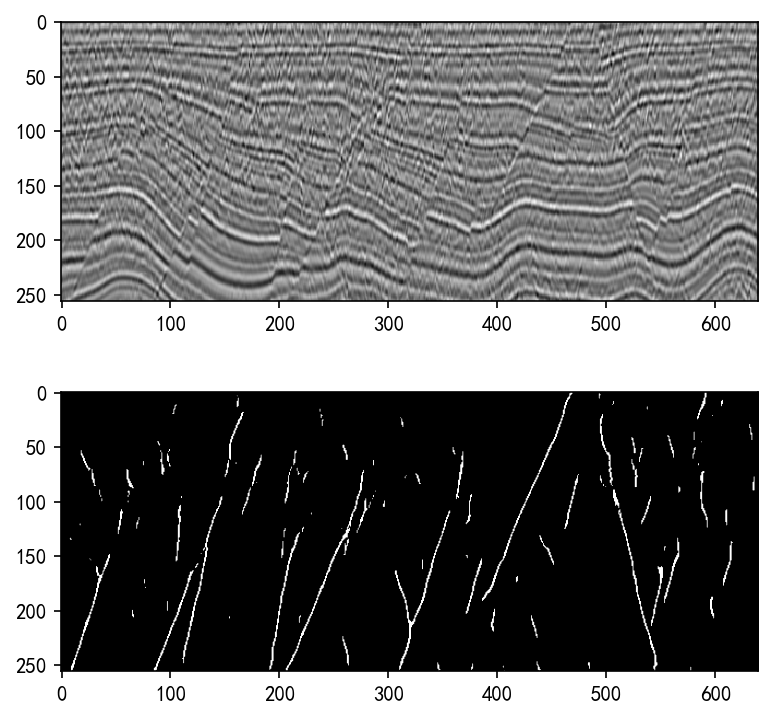

In [24]:
j=50
plt.figure(figsize=(6,6),dpi=150)
plt.subplot(2,1,1)
plt.imshow(np.squeeze(real_test_data[j,:,:,:]),cmap=plt.cm.gray)
plt.subplot(2,1,2)
plt.imshow(np.squeeze(real_result[j,:,:]),interpolation="bilinear",vmin=0.2,vmax=1.0,cmap=plt.cm.gray)

## 7. Output the results as csv and upload it to the kaggle

In [25]:
result_csv = np.reshape(result,(-1))
print(result_csv.shape)

(16384000,)


In [26]:
df = pd.DataFrame(result_csv)
df=df.astype(int)
df=df.astype(str)
df['index'] = range(len(df))
new_col = ['value', 'index']
df.columns = new_col
order = ['index','value']
df=df[order]
df=df.astype(str)
print(df)

             index value
0                0     0
1                1     0
2                2     0
3                3     0
4                4     0
5                5     0
6                6     0
7                7     0
8                8     0
9                9     0
10              10     0
11              11     0
12              12     0
13              13     0
14              14     0
15              15     0
16              16     0
17              17     0
18              18     0
19              19     0
20              20     0
21              21     0
22              22     0
23              23     0
24              24     0
25              25     0
26              26     0
27              27     0
28              28     0
29              29     0
...            ...   ...
16383970  16383970     0
16383971  16383971     0
16383972  16383972     0
16383973  16383973     0
16383974  16383974     0
16383975  16383975     0
16383976  16383976     0
16383977  16383977     0


In [27]:
#choose your own name
df.to_csv('sample.csv',index=False)

In [28]:
import moxing as mox
mox.file.copy('sample.csv','obs://20ai-project/sample.csv')
print("done")

INFO:root:Using MoXing-v1.17.3-
INFO:root:Using OBS-Python-SDK-3.20.7


done
